In [2]:

import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X = mnist['data']
y = mnist['target']
print("shape of X :",X.shape , "shape of y :",y.shape)

shape of X : (70000, 784) shape of y : (70000,)


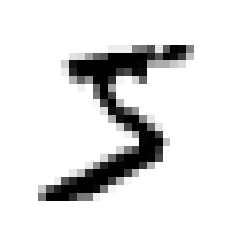

In [4]:
# 2차원 배열로 바꾸지 않으면 이미지를 그릴 수 없다.
image_0 = X[0].reshape(28,28)
plt.imshow(image_0,cmap="binary")
plt.axis("off")
plt.show()

In [5]:
# 타겟값 정수형으로 변경
y = y.astype(np.int8)

In [6]:
#훈련 세트와 테스트 세트 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### 3.2 이진분류기 훈련

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([X[0]])

array([ True])

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### 3.3 성능 측정

#### 3.3.1 교차 검증을 사용한 정확도 측정

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)



for train_idx , test_idx in skfolds.split(X_train,y_train_5):
    x_train_fold = X_train[train_idx]
    y_train_fold = y_train_5[train_idx]
    
    x_test_fold = X_train[test_idx]
    y_test_fold = y_train_5[test_idx]
    
    clone_clf = clone(sgd_clf)
    clone_clf.fit(x_train_fold,y_train_fold)
    y_pred = clone_clf.predict(x_test_fold)
    
    # E(X) = P(X=1) / X~Ber(p)
    print( np.mean( (y_pred == y_test_fold).astype(int) ) )
    

0.9669
0.91625
0.96785


In [12]:
y_train_5.astype(int)

array([1, 0, 0, ..., 1, 0, 0])

In [13]:
#모든 이미지를 '5'가 아니라고 분류함 ( this clf predicts 0 for all data)
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    
    def predict(self,X):
        return np.zeros( (len(X),1) ,dtype=bool )

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

#### 3.3.2 오차행렬

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
# [ [TN,FP] , [FN,TP] ]
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

#### 3.3.3 정밀도와 재현율

In [17]:
from sklearn.metrics import precision_score, recall_score

# 정밀도 = TP / FP + TP , Positive라고 예측한 것에 대한 True Positive의 비율
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
# 재현율 = TP / FN + TP , 실제 양성인 것에 대한 True Positive의 비율 
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
# F1 점수 = 정밀도와 재현율의 조화평균 
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### 3.3.4 정밀도/재현율의 Trade Off

정밀도와 재현율의 차이는 FP 와 FN 의 차이에서 나온다.
임계값을 높히면 양성의 예측은 작아지고 음성의 예측은 많아진다.

In [20]:
y_scores = sgd_clf.decision_function([X[0]])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [24]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

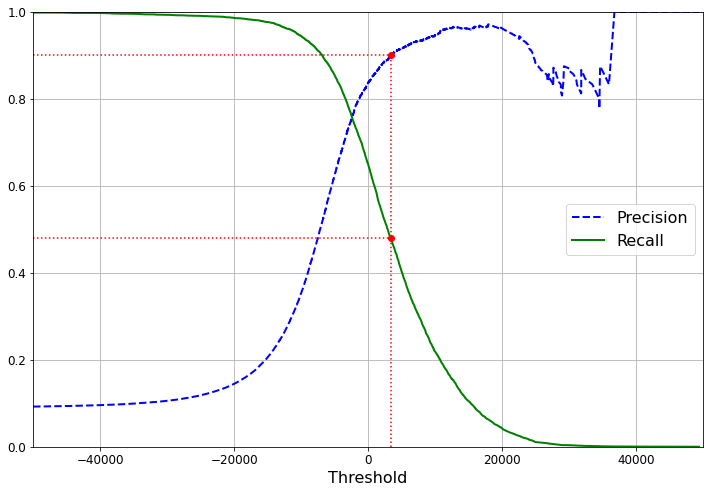

In [25]:
plt.figure(figsize=(12,8))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:") 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")   
plt.legend(loc="center right", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)        
plt.grid(True)                              
plt.axis([-50000, 50000, 0, 1])            
plt.show()


(0.0, 1.0, 0.0, 1.0)

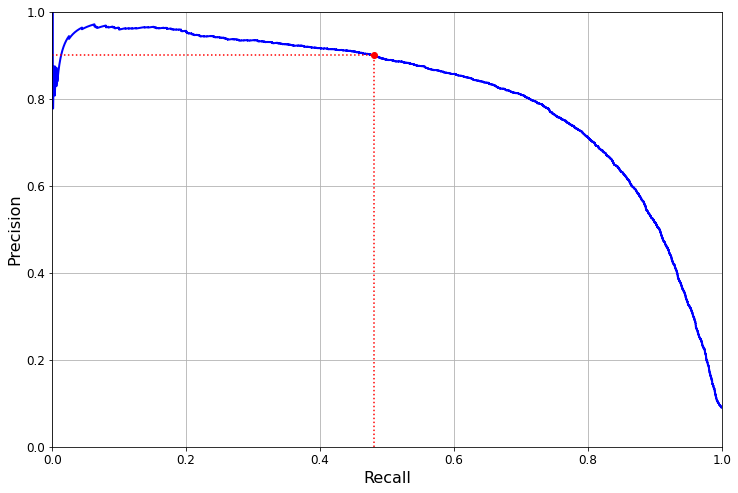

In [26]:
plt.figure(figsize=(12,8))
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.plot([0,recall_90_precision],[0.9,0.9],'r:')
plt.plot([recall_90_precision,recall_90_precision],[0.,0.9],'r:')
plt.plot([recall_90_precision], [0.9], "ro")  
plt.xlabel("Recall", fontsize=16)       
plt.ylabel("Precision", fontsize=16)
plt.grid(True)                             
plt.axis([0.0, 1.0, 0.0, 1.0])            

#### 3.3.5 ROC곡선

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

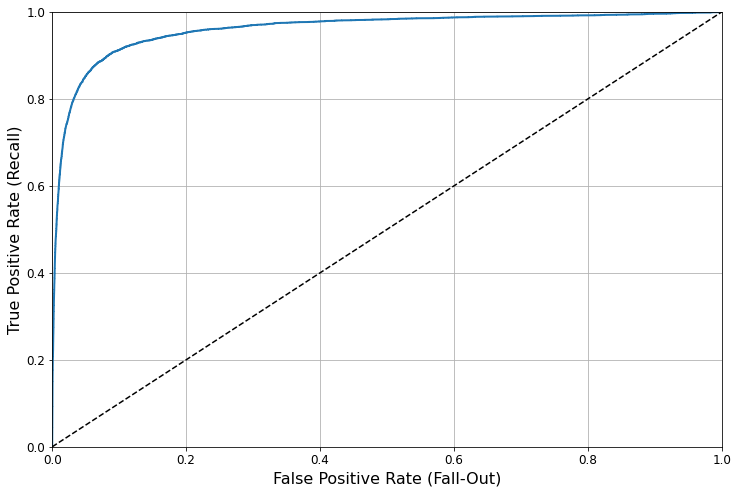

In [28]:
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr,linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # 대각 점선


plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
plt.ylabel("True Positive Rate (Recall)", fontsize=16)    
plt.axis([0.0, 1.0, 0.0, 1.0])
           
plt.grid(True)                                     
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

In [31]:
y_proba_forest[:,1]

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

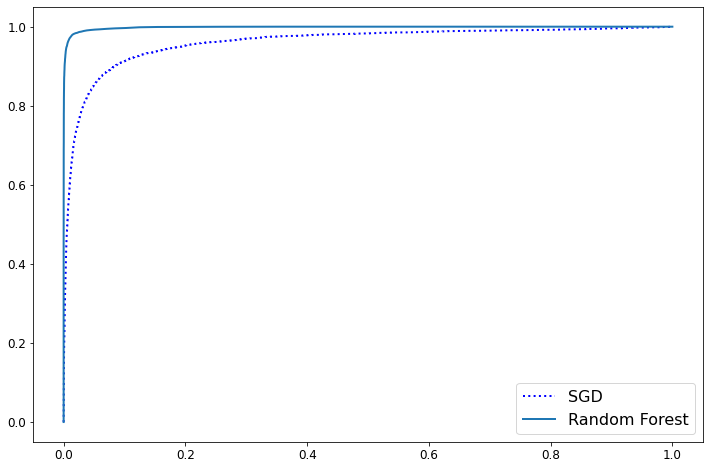

In [32]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_proba_forest[:,1])
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, "b:",label = "SGD", linewidth=2)
plt.plot(fpr_forest, tpr_forest,label = "Random Forest",linewidth=2)
plt.legend(loc="lower right", fontsize=16)
plt.show()

### 3.4 다중분류

In [33]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([X[0]])

array([5], dtype=int8)

In [34]:
svm_clf.decision_function([X[0]])

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [35]:
np.argmax(svm_clf.decision_function([X[0]]))

5

In [36]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(),n_jobs=-1)
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([X[0]])

array([5], dtype=int8)

In [37]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([X[0]])

array([3], dtype=int8)

In [38]:
sgd_clf.decision_function([X[0]])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [39]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [40]:
from sklearn.preprocessing import StandardScaler

#데이터 전처리 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### 3.5 에러분석

In [41]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

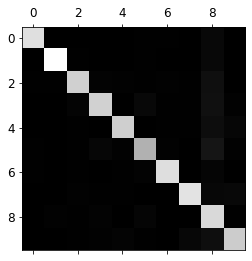

In [42]:
plt.matshow(conf_mx,cmap=plt.cm.gray)

In [43]:
row_sums = conf_mx.sum(axis = 1 , keepdims = True)

In [44]:
norm_conf_mx = conf_mx / row_sums

<Figure size 864x576 with 0 Axes>

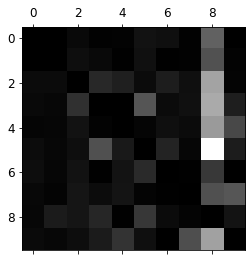

In [45]:
np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize=(12,8))
plt.matshow(norm_conf_mx,cmap = plt.cm.gray)
plt.show()

In [46]:
cl_a = 3
cl_b = 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [47]:
# 숫자 그림을 위한 추가 함수
import math

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = math.ceil(len(instances) / images_per_row)

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

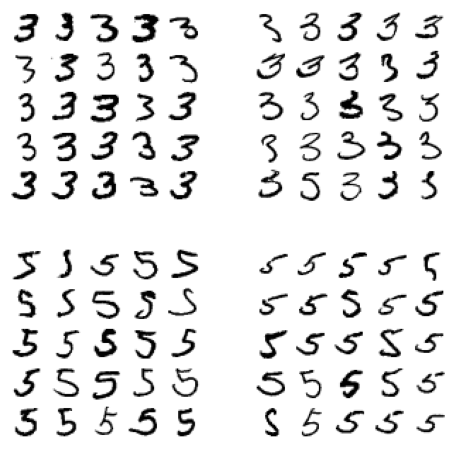

In [48]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


### 3.6 다중 레이블 분류

In [49]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [50]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [51]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [52]:
knn_clf.predict([X[0]])

array([[False,  True]])

### 3.7 다중 출력 분류

In [53]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test                

In [54]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

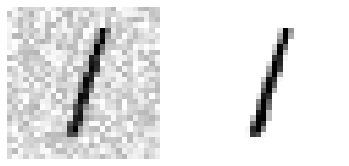

In [55]:
some_idx = 2
plt.subplot(121); plot_digit(X_test_mod[some_idx])
plt.subplot(122); plot_digit(y_test_mod[some_idx])
plt.show()

In [56]:
X_test_mod[0].shape

(784,)

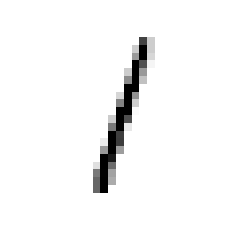

In [57]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_idx]])
plot_digit(clean_digit)

In [2]:
import numpy as np
a = np.array([
    [1,2],
    [3,5],
    [2,8]
])

np.linalg.norm(a - a[0],axis=1)

array([0.        , 3.60555128, 6.08276253])

In [62]:
import pandas as pd
from scipy.stats import mode


data = pd.read_csv("Fish.csv")
data
        

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


In [126]:
X = data[['Length2','Weight']].to_numpy()
X[:10]

array([[ 25.4, 242. ],
       [ 26.3, 290. ],
       [ 26.5, 340. ],
       [ 29. , 363. ],
       [ 29. , 430. ],
       [ 29.7, 450. ],
       [ 29.7, 500. ],
       [ 30. , 390. ],
       [ 30. , 450. ],
       [ 30.7, 500. ]])

In [130]:
y = (data['Species'] == 'Smelt')
y = y.astype(int)
y = y.to_numpy()
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

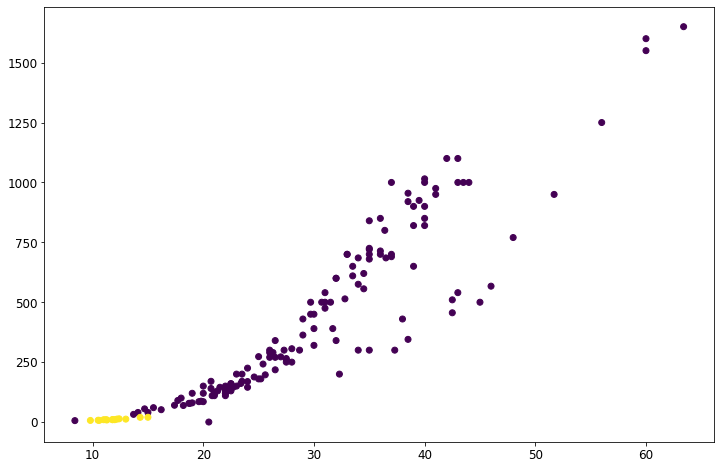

In [88]:
plt.figure(figsize=(12,8))
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [131]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1 , test_size=0.2 , random_state=42)
for train_idx , test_idx in split.split(X,y):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

In [132]:
X_train

array([[  20.8,  110. ],
       [  18.7,   78. ],
       [  10.6,    7. ],
       [  33. ,  700. ],
       [  38.5,  920. ],
       [  31. ,  500. ],
       [  29. ,  430. ],
       [  38.5,  955. ],
       [  23. ,  150. ],
       [  14.1,   40. ],
       [  11.2,    9.8],
       [  22. ,  130. ],
       [  22. ,  135. ],
       [  19.8,   87. ],
       [  56. , 1250. ],
       [  22.5,  140. ],
       [  35. ,  700. ],
       [  11.8,   10. ],
       [  32.8,  514. ],
       [  60. , 1550. ],
       [  33.5,  610. ],
       [  37.3,  300. ],
       [  21.3,  130. ],
       [  11.3,    8.7],
       [  19. ,   80. ],
       [  38.5,  345. ],
       [  36. ,  850. ],
       [  30. ,  320. ],
       [  21. ,  110. ],
       [  22. ,  110. ],
       [  43. , 1000. ],
       [  43.5, 1000. ],
       [  19. ,  120. ],
       [  24.6,  188. ],
       [  22.7,  145. ],
       [  34.5,  556. ],
       [  22.5,  160. ],
       [  41. ,  975. ],
       [  11. ,    9.7],
       [  26.5,  218. ],


In [133]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

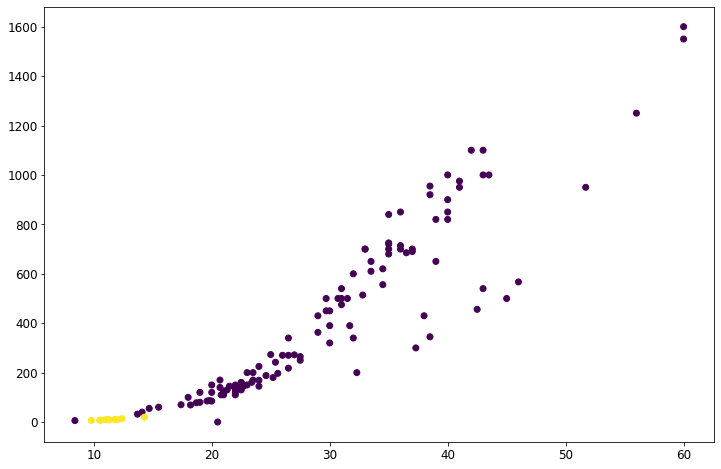

In [94]:
plt.figure(figsize=(12,8))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.show()

In [96]:
X_train.shape

(127, 2)

In [97]:
X_test.shape

(32, 2)

In [98]:
m = X_test.shape[0]
n = X_train.shape[0]
k = 5     
metric = np.zeros((m,n))

for i in range(m):
    #calculate distance
    metric[i] = np.linalg.norm( (X_train - X_test[i]) , axis = 1 )
    


In [134]:
mode( y_train[np.argsort(metric[1])[0:k]] )[0][0]

0

In [141]:
y_pred = np.zeros(m)
for i in range(m):
    y_pred[i] = mode( y_train[np.argsort(metric[i])[1:k+1]] )[0][0]

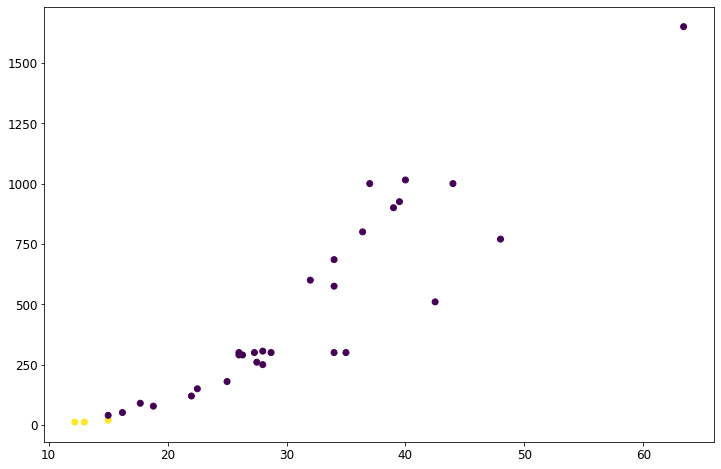

In [142]:
plt.figure(figsize=(12,8))
plt.scatter(X_test[:,0],X_test[:,1],c=y_pred)
plt.show()

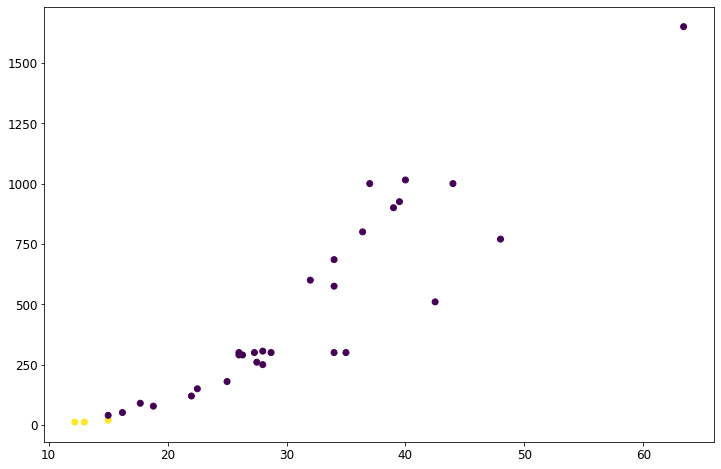

In [139]:
plt.figure(figsize=(12,8))
plt.scatter(X_test[:,0],X_test[:,1],c=y_test)
plt.show()

In [143]:
np.mean( y_test == y_pred )

1.0

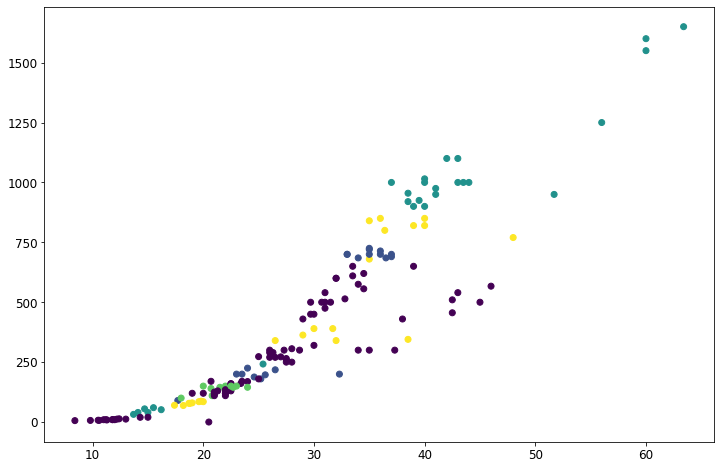

In [87]:
plt.figure(figsize=(12,8))
plt.scatter(X[:,0],X[:,1],c=c)
plt.show()

In [11]:
from knn_clf import knn_clf

knn_clf = knn_clf()
knn_clf.fit(X_train[:1000],y_train[:1000])

In [52]:
import numpy as np
from scipy.stats import mode
from sklearn.base import BaseEstimator

class knn_clf(BaseEstimator):
    """_summary_
    K Nearest Neighnors classifier
    """
    def __init__(self,n_neighbors = 5) -> None:
        self.n_neighnors = n_neighbors
        self.X = None
        self.c = None

    def fit(self,X : np.array, y : np.array):
        """_summary_
        Args:
            X (np.array): dataset
        """
        self.X = X.copy()
        self.c = y.copy()
        
            
    def predict(self,X : np.array):
        
        m = X.shape[0]
        n = self.X.shape[0]
        k = self.n_neighnors
        metric = np.zeros((m,n))
        
        y_pred = np.zeros(m)
        
        for i in range(m):
            #calculate distance
            metric[i] = np.linalg.norm( (self.X - X[i]) , axis = 1 )
            
        for i in range(m):
            y_pred[i] = mode( self.c[np.argsort(metric[i])[0:k]] )[0][0]     
        
    
        return y_pred
    

In [54]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist['data']
y = mnist['target']

y = y.astype(int)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]



In [63]:
knn = knn_clf()
knn.fit(X_train[:10000],y_train[:10000])

y_pred = knn.predict(X_test)

print(y_pred , y_test , np.mean(y_pred == y_test))

KeyboardInterrupt: 

In [60]:
X_test[:10].shape[0]

10

In [47]:
X = X_train[:1000]
y = y_train[:1000]

_X = X_test[:100]
_y = y_test[:100]

n = X.shape[0]
m = _X.shape[0]
k = 5
metric = np.zeros((m,n))
y_pred = np.zeros(m)


for i in range(m):
    #calculate distance
    metric[i] = np.linalg.norm( (X - _X[i]) , axis = 1 )

In [48]:
y_pred = np.zeros(m)

for i in range(m):
    y_pred[i] = mode(y[np.argsort(metric[i])[0:k]] )[0][0]   

In [50]:
y_pred

array([7., 2., 1., 0., 4., 1., 9., 9., 4., 7., 0., 6., 9., 0., 1., 3., 9.,
       7., 2., 9., 9., 6., 4., 5., 4., 0., 7., 4., 0., 1., 3., 1., 3., 4.,
       7., 2., 7., 1., 2., 1., 1., 7., 4., 1., 1., 5., 1., 4., 4., 4., 6.,
       3., 5., 5., 6., 0., 4., 1., 9., 1., 7., 8., 9., 9., 7., 4., 0., 4.,
       3., 0., 7., 0., 2., 7., 1., 7., 3., 2., 9., 7., 9., 6., 2., 7., 8.,
       4., 7., 3., 6., 1., 3., 6., 9., 3., 1., 9., 1., 7., 6., 9.])

In [51]:
np.mean( y_pred == y_test[:100].astype(int) )

0.84